# <span style="color:brown"> **Hands-on Deep Learning – Image Classification**

_This hands-on was originally created by Thomas Grenier (TensorFlow) and Fabien Millioz (PyTorch), CREATIS.

thomas.grenier@creatis.insa-lyon.fr,
michael.sdika@creatis.insa-lyon.fr,
olivier.bernard@creatis.insa-lyon.fr,
odyssee.merveille@creatis.insa-lyon.fr,
fabien.millioz@creatis.insa-lyon.fr

# <span style="color:brown"> **Introduction on data**

This hands-on is computer scientist-oriented more than application-oriented.

And so, this practice focuses on a meaningless toy example inspired from the MNIST manuscript numbers classification challenge that is considered as the 'hello world' example for some machine learning and almost all neural networks.

MR images come from [IXI Dataset](https://brain-development.org/ixi-dataset/)

Here, we have to recognize whether a brain slice image is axial, sagittal or coronal and comes from MRI T1w, MRI T2w and Proton Density MR (PD). So, this is a classification problem with 9 classes, as follows:
   
<img src="./figures/Figure1_SagittalAxialCoronal_small.png" alt="SagittalAxialCoronal" style="width: 70%"/>

Amount of images of each class for train and test datasets is :  
- Total images for training:
   - PD-A (PD Axial)    : 2701
   - PD-C (PD Coronal)  : 2723
   - PD-S (PD Sagittal) : 2698
   - T1-A (T1 Axial)    : 2715
   - T1-C (T1 Coronal)  : 2758
   - T1-S (T1 Sagittal) : 2711
   - T2-A (T2 Axial)    : 2696
   - T2-C (T2 Coronal)  : 2717
   - T2-S (T2 Sagittal) : 2699
- Total images for testing:
   - PD-A (PD Axial)     : 689
   - PD-C (PD Coronal)   : 696
   - PD-S (PD Sagittal)  : 693
   - T1-A (T1 Axial)     : 679
   - T1-C (T1 Coronal)   : 685
   - T1-S (T1 Sagittal)  : 676
   - T2-A (T2 Axial)     : 684
   - T2-C (T2 Coronal)   : 690
   - T2-S (T2 Sagittal)  : 686

We have enough data to test classification approaches such as random forest, MLP and CNN.

> Let's go!



# <span style="color:brown"> **A - Setup**

### A1 - First, import a few common modules, ensure MatplotLib plots figures inline, and functions for converting data and displaying reports:

In [1]:
# Common imports
import os
import glob

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import numpy as np

!pip install tqdm
from tqdm import tqdm

!pip install scikit-learn
from sklearn import datasets, metrics

# if trouble with libGL consider to execute this line in a shell: apt-get install python3-opencv
# !pip install opencv-python
import cv2


     |████████████████████████████████| 78 kB 3.5 MB/s eta 0:00:011
     |████████████████████████████████| 30.8 MB 3.5 MB/s eta 0:00:01     |█████████████████████████▍      | 24.4 MB 3.5 MB/s eta 0:00:02
     |████████████████████████████████| 306 kB 92.1 MB/s eta 0:00:01


### A2- We import TensorFlow 2

In [2]:
import tensorflow as tf
print(tf.__version__)

2022-07-17 14:53:05.751193: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


2.4.1


> _**if no error occurs, your working environment is ok and you can go to next part,
> else ... call an assistant for help!**_

# <span style="color:brown"> **B - Read the data**

<span style="color:red">
    

We first download the data and then deflate them.

In [3]:
!rm dlss21_ho1_data.tar.gz
!wget "https://gitlab.in2p3.fr/thomas.grenier/tp1ss_classification/-/raw/master/dlss21_ho1_data.tar.gz"
#!wget "https://www.creatis.insa-lyon.fr/~grenier/wp-content/uploads/teaching/DeepLearning/dlss21_ho1_data.tar.gz"
!tar xzf dlss21_ho1_data.tar.gz

rm: cannot remove 'dlss21_ho1_data.tar.gz': No such file or directory
--2022-07-17 14:53:12--  https://gitlab.in2p3.fr/thomas.grenier/tp1ss_classification/-/raw/master/dlss21_ho1_data.tar.gz
Resolving gitlab.in2p3.fr (gitlab.in2p3.fr)... 134.158.69.41
Connecting to gitlab.in2p3.fr (gitlab.in2p3.fr)|134.158.69.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54241580 (52M) [application/x-gzip]
Saving to: ‘dlss21_ho1_data.tar.gz’

dlss21_ho1_data.tar 100%[===================>]  51.73M  13.7MB/s    in 3.8s    

2022-07-17 14:53:17 (13.7 MB/s) - ‘dlss21_ho1_data.tar.gz’ saved [54241580/54241580]



### <span style="color:brown"> **B1 - Open files and convert to numpy / tensorflow** 

Now start by reading _png_ files stored in the data train and test directories. 
Note that the filename of the _png_ image describes which view (Axial, Coronal, Sagital) and modality (T1w, T2w and PD) correspond to the image.

These _png_ correspond to slices extracted from 3D volumes of the [IXI dataset](https://brain-development.org/ixi-dataset/). In order to reduce the data variability (and simplify the slice extraction scripts), all MRI volumes were registered on a reference image using [elastix](http://elastix.isi.uu.nl/) with an affine transform. 

Thus, origin, spacing, orientation and number of pixels per dimension of all volumes are the same and therefore will not need to be taken into account systematically by the learning scripts (using SimpleITK, MedPy, nibabel...).

Then, slices are extracted and the window/level was adapted (using [ITK](https://itk.org/)).

Finally, they were resized then padded/cropped to 64x64 using [ImageMagick](https://www.imagemagick.org/).

Image files in __dlss21_ho1_data/train/__  are organized as follow:
  - dlss21_ho1_data/train/PD-A/002_116_PD-A.png
                              /002_42_PD-A.png
                              /002_44_PD-A.png
                              /002_53_PD-A.png
                               ...
  - dlss21_ho1_data/train/PD-C/002_152_PD-C.png
                              /002_175_PD-C.png
                              /002_177_PD-C.png
                              /002_198_PD-C.png
                               ...
  - dlss21_ho1_data/train/PD-S/...
  - dlss21_ho1_data/train/T1-A/...
  - dlss21_ho1_data/train/T1-C/...
  - dlss21_ho1_data/train/T1-S/...
  - dlss21_ho1_data/train/T2-A/...
  - dlss21_ho1_data/train/T2-C/...
  - dlss21_ho1_data/train/T2-S/...

And the same for __dlss21_ho1_data/test/__ with different subjects than ones present in the train set.


> The next cells will open all images and create three datasets containing the images and the corresponding labels.


Some important values and initializations:

In [4]:
desired_height = 64
desired_width  = 64

input_train_path = os.getcwd()+'/dlss21_ho1_data/train'           
input_test_path = os.getcwd()+'/dlss21_ho1_data/test'            
print(f"input train path : {input_train_path}")
print(f"input test path  : {input_test_path}")

class_names = ['PD-A', 'PD-C', 'PD-S', 'T1-A', 'T1-C', 'T1-S', 'T2-A', 'T2-C', 'T2-S']

input train path : /home/jovyan/workspace/dlss21_ho1_data/train
input test path  : /home/jovyan/workspace/dlss21_ho1_data/test


In [5]:
# first list files for the train and validation sets.
train_val_image_file_list = []
train_val_label_list = []

for i in range(len(class_names)):
    for filename in glob.iglob( os.path.join(input_train_path,class_names[i]) + '/**/*.png', recursive=True):
        # extract patient number and slice
        train_val_image_file_list.append(filename)
        train_val_label_list.append( i )     

print(len(train_val_image_file_list), len(train_val_label_list))
print(train_val_image_file_list[0])

24418 24418
/home/jovyan/workspace/dlss21_ho1_data/train/PD-A/253_109_PD-A.png


In [6]:
# Random permutation
permutation = np.random.permutation( len(train_val_label_list) )
train_val_images_files=[train_val_image_file_list[i] for i in permutation]
train_val_labels=[train_val_label_list[i] for i in permutation]

In [7]:
# we split the train set in two parts : train and validation
VALIDATION_RATIO = 0.2
nb_train = int( len(train_val_label_list) * (1 - VALIDATION_RATIO) )
# list images for both datasets
train_images_files = train_val_images_files[:nb_train]
train_labels =train_val_labels[:nb_train]

val_images_files = train_val_images_files[nb_train:]
val_labels = train_val_labels[nb_train:]

# for labels also convert them to numpy
y_train = np.asarray(train_labels)
y_val = np.asarray(val_labels)

print( train_val_images_files[0])

/home/jovyan/workspace/dlss21_ho1_data/train/T1-C/244_155_T1-C.png


In [8]:
# Reading images 
def ReadImages(images_files):
    X = []
    for index in tqdm(range(len(images_files))):
        image_read = cv2.imread(images_files[index], cv2.IMREAD_COLOR)
        image_read = cv2.resize(image_read, dsize = (desired_width, desired_height), interpolation = cv2.INTER_LINEAR)
        X.append(image_read)
    X = np.asarray(X, dtype=np.uint8)
    return X

In [9]:
# Read images
X_train_rgb = ReadImages(train_images_files)
X_val_rgb   = ReadImages(val_images_files)

100%|██████████| 4884/4884 [00:00<00:00, 12285.67it/s]


### <span style="color:brown"> **B2 - Check the output data size and type**
We recommend to check as often as needed the shape and type of data.

Don't go further if you can't see what is inside array and tensor!

In [10]:
# Show information
print(" Shape : " , X_train_rgb.shape, X_val_rgb.shape)
print(" Type  : %s  %s"%(X_train_rgb.dtype, X_val_rgb.dtype))
print(" Max   : %d  %d"%(X_train_rgb.max(), X_val_rgb.max()))
print(" Min   : %d  %d"%(X_train_rgb.min(), X_val_rgb.min()))

print(" Labels Shape : " , y_train.shape, y_val.shape)

 Shape :  (19534, 64, 64, 3) (4884, 64, 64, 3)
 Type  : uint8  uint8
 Max   : 255  255
 Min   : 0  0
 Labels Shape :  (19534,) (4884,)


### <span style="color:brown"> **B3 - Displaying images**

In [11]:
def plot_image(image):
    plt.imshow(image, aspect="equal", cmap="gray", interpolation="nearest")
    plt.axis("off")    

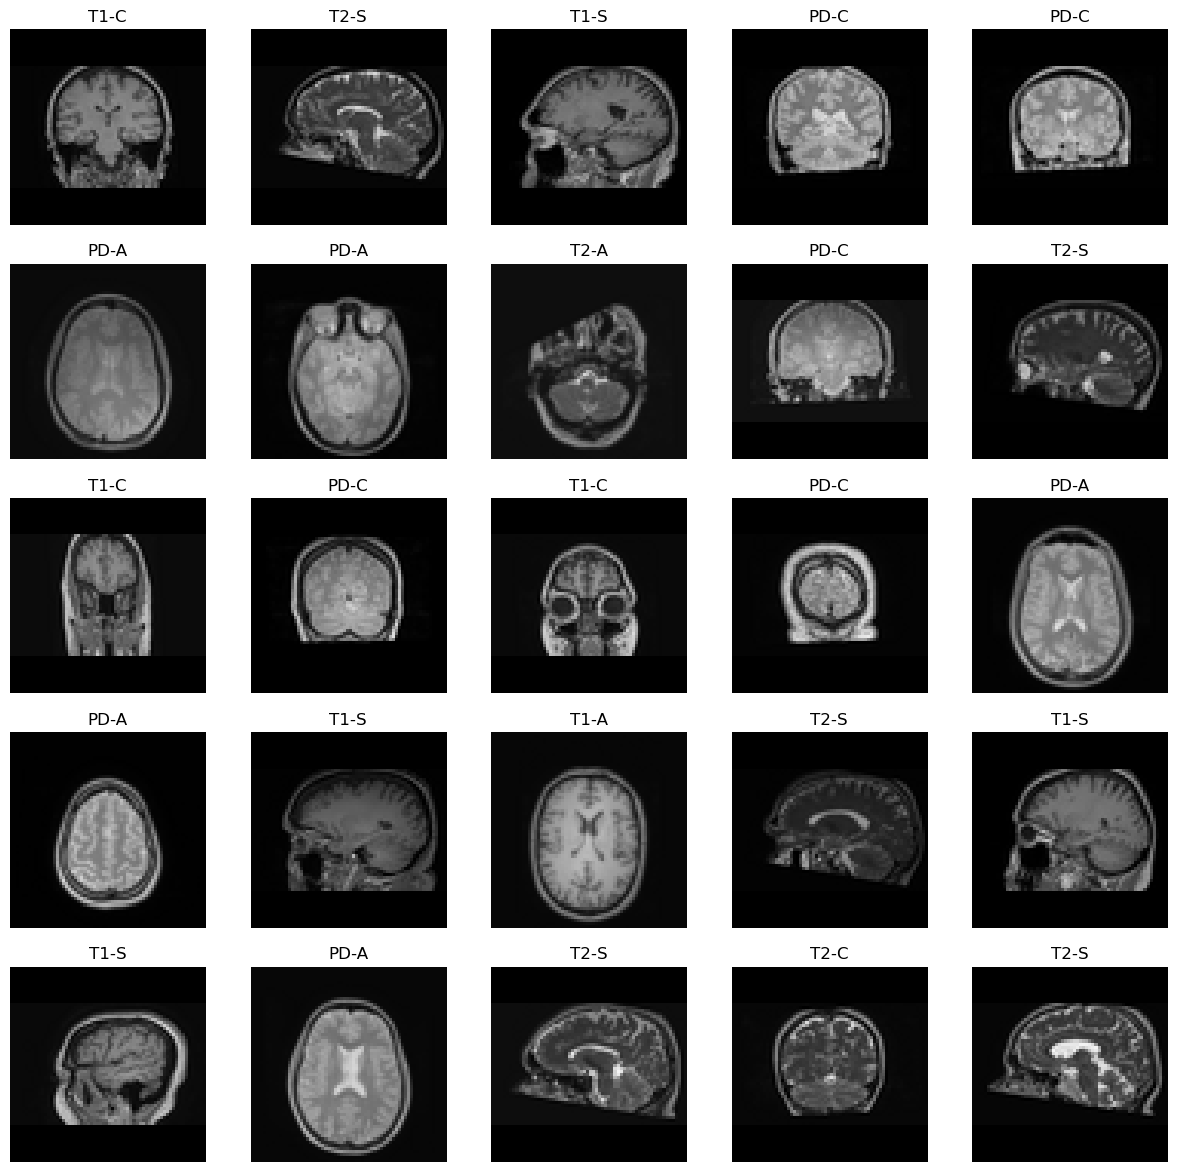

In [12]:
nb_x = 5
nb_y = 5
plt.figure(figsize=(15,15*nb_x/nb_y), dpi=100)
for i in range(1, nb_x * nb_y +1):
    plt.subplot(nb_x, nb_y ,i)
    plot_image( X_train_rgb[i-1] )
    plt.title(class_names[y_train[i-1]])

### <span style="color:brown"> **B4 - Test set**

6178 6178


100%|██████████| 6178/6178 [00:00<00:00, 12717.06it/s]


 Shape :  (6178, 64, 64, 3) (6178,)
 Type  : uint8  int64
 Max   : 255  8
 Min   : 0  0


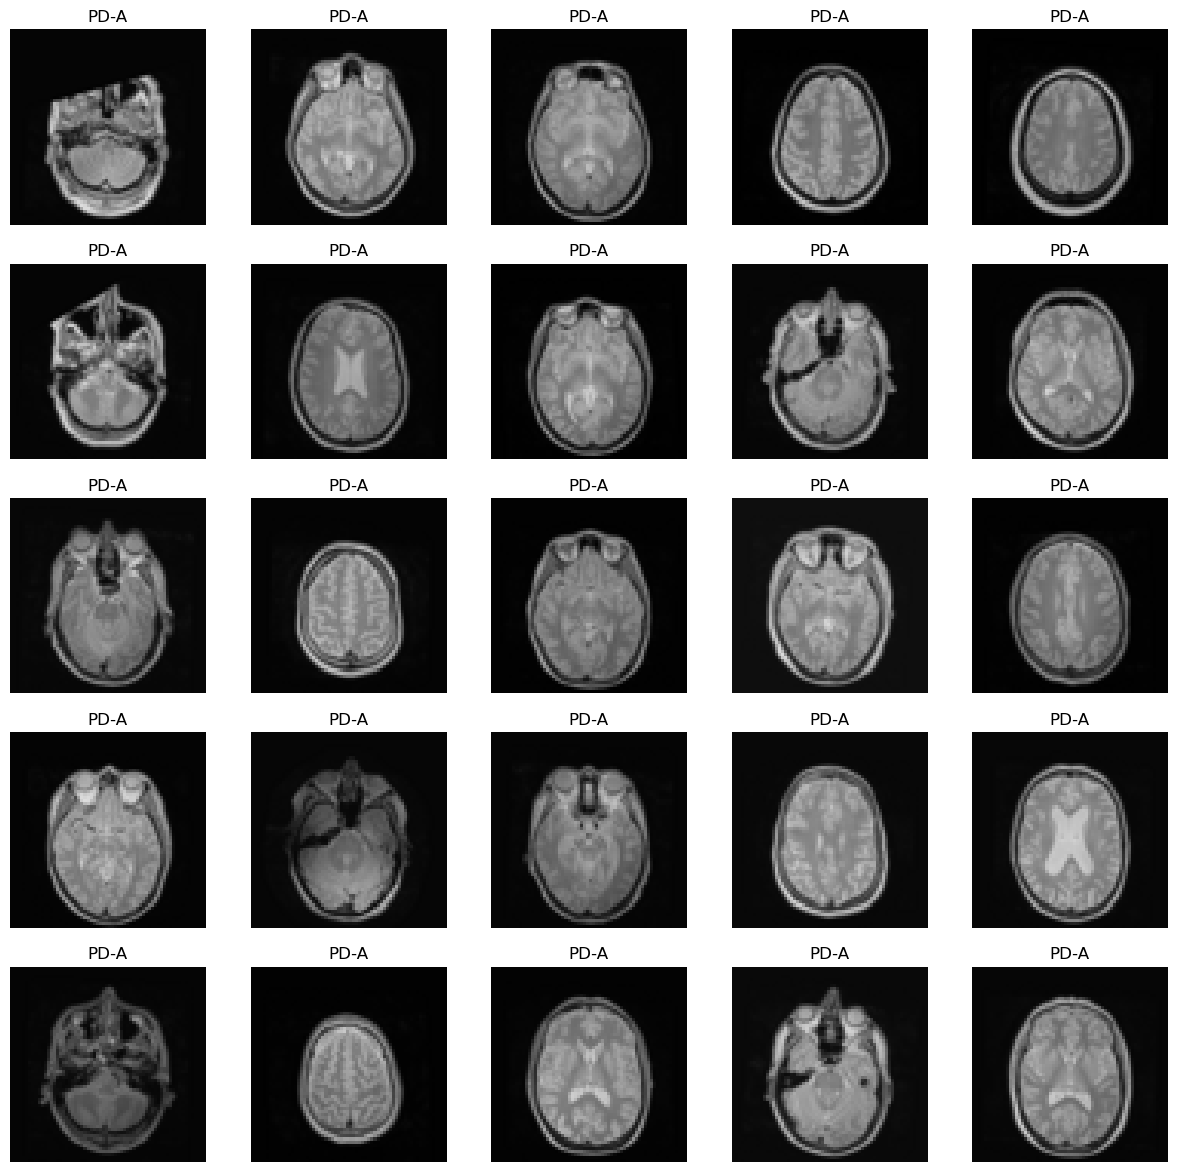

In [13]:
# doing the same for test set
test_image_file_list = []
test_label_list = []
           
for i in range(len(class_names)):
    for filename in glob.iglob( os.path.join(input_test_path,class_names[i]) + '/**/*.png', recursive=True):
        # extract patient number and slice
        test_image_file_list.append(filename)
        test_label_list.append( i )            

print(len(test_image_file_list), len(test_label_list))

X_test_rgb = ReadImages(test_image_file_list)
y_test = np.asarray(test_label_list)

print(" Shape : " , X_test_rgb.shape, y_test.shape)
print(" Type  : %s  %s"%(X_test_rgb.dtype, y_test.dtype))
print(" Max   : %d  %d"%(X_test_rgb.max(), y_test.max()))
print(" Min   : %d  %d"%(X_test_rgb.min(), y_test.min()))

nb_x = 5
nb_y = 5
plt.figure(figsize=(15,15*nb_x/nb_y), dpi=100)
for i in range(1, nb_x * nb_y +1):
    plt.subplot(nb_x, nb_y ,i)
    plot_image( X_test_rgb[i-1] )
    plt.title(class_names[y_test[i-1]])
# here we have not shuffle filenames :p

Verify shapes that should look like ( batch_size, desired_height, desired_width, 3 ) and (batch_size, )

### <span style="color:brown"> **B5 - Convert the data shape and type**
The _png_ files are RGB, we convert them to gray images for each set (train, validation and test) in order to be compatible with all tested approaches.

We also divide intensity values by 255 to bound range in [0;1]


 Shape :  (19534, 64, 64, 1) (4884, 64, 64, 1) (6178, 64, 64, 1)
 Type  : float32  float32 float32
 Max   : 1 1 1
 Min   : 0 0 0


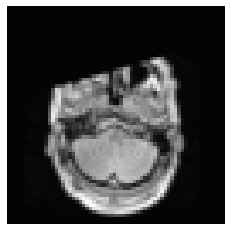

In [14]:
# converting the three data set : rgb to gray scale images, then normalization

X_train = X_train_rgb[:,:,:,1].astype(np.float32)/255
X_train = np.expand_dims(X_train,-1)

X_val = X_val_rgb[:,:,:,1].astype(np.float32)/255
X_val = np.expand_dims(X_val,-1)

X_test = X_test_rgb[:,:,:,1].astype(np.float32)/255
X_test = np.expand_dims(X_test,-1)

print(" Shape : ", X_train.shape, X_val.shape, X_test.shape)
print(" Type  : %s  %s %s"%(X_train.dtype, X_val.dtype, X_test.dtype))
print(" Max   : %d %d %d"%(X_train.max(), X_val.max(), X_test.max()) )
print(" Min   : %d %d %d"%(X_train.min(),X_val.min(), X_test.min()) )
plot_image( X_test[0].squeeze() )

An other way of representing labels is the one hot encoding form. MAny mathematical function can easly be generalized using this notation.
If they are 4 different labels, the sparse notation becomes:
   - label '0' --> 1 0 0 0
   - label '1' --> 0 1 0 0
   - label '2' --> 0 0 1 0
   - label '3' --> 0 0 0 1

This conversion can be done using a dedicated function:

In [15]:
y_train_cat = tf.keras.utils.to_categorical(y_train)
y_val_cat = tf.keras.utils.to_categorical(y_val)
y_test_cat = tf.keras.utils.to_categorical(y_test)

print(" Original (sparse) shape  : ", y_train.shape, y_val.shape, y_test.shape)
print(" Categorical shape  : ", y_train_cat.shape, y_val_cat.shape, y_test_cat.shape)
print(" Example : ", y_train[0,], " --> " ,y_train_cat[0,])

# Now changing name :
y_train = y_train_cat
y_val = y_val_cat
y_test = y_test_cat

 Original (sparse) shape  :  (19534,) (4884,) (6178,)
 Categorical shape  :  (19534, 9) (4884, 9) (6178, 9)
 Example :  4  -->  [0. 0. 0. 0. 1. 0. 0. 0. 0.]


### <span style="color:red"> **Question**
- What means the 9 for the last axis of y_train_cat, y_val_cat, y_test_cat?

> _**All done, go to the classification step!**_

# <span style="color:brown"> **Classification**

### Function for displaying reports

In [16]:
# Usage example : ClassificationReport(model, X_test, y_test_cat , class_names)
def ClassificationReport(model, X_test, y_test_cat, labels_name):  
    # predict 
    print("Prediction on test images")
    predicted = model.predict(X_test)
    y_pred = np.argmax(predicted, axis=-1)
    y_test = np.argmax(y_test_cat, axis=-1)
    
    print("Classification report :\n%s\n"
         % (metrics.classification_report(y_test, y_pred)) )
    cm = metrics.confusion_matrix( y_test, y_pred )
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,  display_labels=labels_name)
    disp.plot()
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()

## <span style="color:brown"> **C - Classification with random forest**
    
First, we want to use a random forest to perform the classification. A random forest is an ensemble of decision trees. 
    
Each decision tree takes as input a feature vector. In our application, the feature vector is the grey-level values of the 32x32 (=1024 features) patch centered on each slice. 
    
During training, a matrix (X_train_crop) of size Nx1024 (N is the number of training images) is fed to the algorithm to build a decision tree. Learning the decision tree consists in finding the combination of features and cut-off values ($\alpha_i$) of each node such that the loss is minimal.
    
During test, the feature vector of one image is given to the learnt decision tree and goes through the first node. If the value of the feature (i.e. $f_5$ in the example) is higher than the cut-off value ($\alpha_0$), we proceed to the left branch, otherwise we proceed to the righ branch. This process is repeated until a leaf is reached, which will correspond to the predicted class.
    
A random forest is an ensemble of decision trees. M (M = 10 in the code below) decisions trees are learnt, each one from a subsample of the N training images. The final prediction is performed by a majority vote over the M predictions.
            
<center><img src="./figures/decision_tree.png" alt="Decision Tree" style="width: 50%"/></center>

In [17]:
# here we prepare data for scikit-learn

# crop around the image center
crop_min = 32-16
crop_max = 32+16 +1 # '+1' is for python indexes : [0:10] corresponds to indexes 0 to 9 

# flattening for scikit-learn (ie a 64x64 image -> a vector of 4096 elements)
X_train_crop = []
for i in range(0, X_train.shape[0]):
    X_train_crop.append( X_train[i,crop_min:crop_max,crop_min:crop_max, 0].flatten() )
X_train_crop = np.asarray( X_train_crop )

X_val_crop = []
for i in range(0, X_val.shape[0]):
    X_val_crop.append( X_val[i,crop_min:crop_max,crop_min:crop_max, 0].flatten() )
X_val_crop = np.asarray( X_val_crop )

X_test_crop = []
for i in range(0, X_test.shape[0]):
    X_test_crop.append( X_test[i,crop_min:crop_max,crop_min:crop_max, 0].flatten() )
X_test_crop = np.asarray( X_test_crop )

print(" X_train_crop shape : ", X_train_crop.shape )
print(" y_train      shape : ", y_train.shape )
print(" X_val_crop   shape : ", X_val_crop.shape )
print(" y_val        shape : ", y_val.shape )
print(" X_test_crop  shape : ", X_test_crop.shape )
print(" y_test       shape : ", y_test.shape )

 X_train_crop shape :  (19534, 1089)
 y_train      shape :  (19534, 9)
 X_val_crop   shape :  (4884, 1089)
 y_val        shape :  (4884, 9)
 X_test_crop  shape :  (6178, 1089)
 y_test       shape :  (6178, 9)


In [28]:
from sklearn import ensemble
classifier = ensemble.RandomForestClassifier(n_estimators=45, max_depth=12, max_features ='auto', n_jobs=4, verbose=1)
#classifier = ensemble.GradientBoostingClassifier(n_estimators=10, max_depth=5, max_features ='auto', verbose=1) # can be very long !

print("Train model")
classifier.fit(X_train_crop, y_train)

print("Compute predictions")
y_pred = classifier.predict(X_test_crop)

Train model


/srv/conda/envs/saturn/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


Compute predictions


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:    7.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:    0.1s finished


Classification report for classifier Random Forest :
              precision    recall  f1-score   support

           0       0.78      0.98      0.87       689
           1       1.00      0.95      0.97       696
           2       1.00      0.95      0.98       693
           3       0.99      0.94      0.97       679
           4       0.99      0.95      0.97       685
           5       1.00      0.97      0.98       676
           6       0.98      0.96      0.97       684
           7       0.98      0.95      0.96       690
           8       0.97      0.98      0.98       686

    accuracy                           0.96      6178
   macro avg       0.97      0.96      0.96      6178
weighted avg       0.97      0.96      0.96      6178




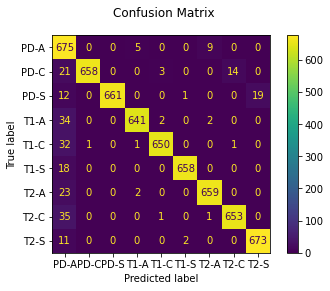

In [29]:
# evaluation
print("Classification report for classifier Random Forest :\n%s\n"
         % (metrics.classification_report(np.argmax(y_test, axis=-1), np.argmax(y_pred, axis=-1) )) )
cm = metrics.confusion_matrix( np.argmax(y_test, axis=-1), np.argmax(y_pred, axis=-1) )
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,  display_labels=class_names)
disp.plot()
disp.figure_.suptitle("Confusion Matrix")
plt.show()

### <span style="color:red"> **Questions**
- Modify the classification parameters to improve the accuracy. Objective : accuracy > 95%
- What do you think of the level of performance achieved?
- Try to test other classification approaches from [scikit-learn](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)

## <span style="color:brown"> **D - Classification with Networks**


### <span style="color:brown"> **D1 - Multi-Layer Perceptron**

In order to enter step by step into the world of deep learning, we will first look at the problem of classification of the [IXI dataset](https://brain-development.org/ixi-dataset/) using one of the simple network dedicated to such task, i.e. the multi-layer perceptron (also called a fully connected network - FCN). The corresponding architecture is provided below.

<center><img src="./figures/architecture_fcn_en.png" alt="Architecture FCN" style="width: 50%"/></center>

The execution of the cell below will allow you to load in memory the functions (actions) and constants that you will use afterwards. 

In [51]:
# Declaration of functions that will be used from the standard  tensorflow library
from tensorflow.keras import optimizers
from tensorflow import losses

# Definition of constants
input_shape = (desired_height,desired_width,1)
input_shape_rgb = (desired_height,desired_width,3)
num_classes = 9

<span style="color:#ff7800"><b>Comment</b>: You can play with the value of some typical parameters by executing the cell below. During your session, feel free to go back to this cell, change some values and re-run the code from this cell to see the impact on the results.</span>

In [62]:
# Definition of variables that you will have to play with during the session to study their influence

# Variables related to the FCN architecture
nb_mlp_neurons = 32    # Number of neurons for one layer

# Variables related to the optimization process
batch_size    = 16     # Number of images for each batch during the training process 
nb_epochs     = 12    # number of epochs used during the training process
learning_rate = 0.002  # learning rate used during the training process

Run the cell below to create a FCN (Fully Connected Network) model using a sequential declaration allowed by the tensorflow library

In [63]:
# This part of the code allows you to free up memory space 
if 'model' in locals(): 
    print("deleting model")
    del model

# Define a FCN model from sequential declaration
model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=input_shape),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(nb_mlp_neurons, activation='relu'),# a fully-connected layer with nb_mlp_neurons hidden units
  tf.keras.layers.Dense(nb_mlp_neurons, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation = 'softmax')
])

# Display the network structure on the console
model.summary()

deleting model
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 4096)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 32)                131104    
_________________________________________________________________
dense_25 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_26 (Dense)             (None, 9)                 297       
Total params: 132,457
Trainable params: 132,457
Non-trainable params: 0
_________________________________________________________________


### <span style="color:red"> **Questions**
- Analyze the description of the network that appears above and try to make the link with the diagram of the fully connected network given on the figure above.    
- How many parameters does this network have in total ?
- Can you explain the 153 parameters that appear for the last layer (named dense_1) ?

It's time to start your first training by running the following cell !

In [64]:
# Compile (define the optimization scheme) the model to be ready for training
model.compile(
  optimizer=optimizers.SGD(learning_rate=learning_rate),
  #optimizer=optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999),
  
  loss=losses.CategoricalCrossentropy(),
  #loss=losses.CategoricalHinge(),
  metrics=['accuracy'])

# Train the model
model.fit(
  X_train, y_train_cat,
  validation_data=(X_val, y_val_cat),
  batch_size=batch_size,  
  epochs=nb_epochs
)

Epoch 1/12
1221/1221 [==============================] - 3s 2ms/step - loss: 1.7273 - accuracy: 0.3373 - val_loss: 0.9094 - val_accuracy: 0.6882
Epoch 2/12
1221/1221 [==============================] - 2s 2ms/step - loss: 0.7907 - accuracy: 0.7250 - val_loss: 0.5615 - val_accuracy: 0.7987
Epoch 3/12
1221/1221 [==============================] - 2s 2ms/step - loss: 0.4998 - accuracy: 0.8723 - val_loss: 0.3939 - val_accuracy: 0.9161
Epoch 4/12
1221/1221 [==============================] - 2s 2ms/step - loss: 0.3647 - accuracy: 0.9203 - val_loss: 0.2957 - val_accuracy: 0.9308
Epoch 5/12
1221/1221 [==============================] - 2s 2ms/step - loss: 0.2756 - accuracy: 0.9418 - val_loss: 0.2322 - val_accuracy: 0.9515
Epoch 6/12
1221/1221 [==============================] - 2s 2ms/step - loss: 0.2182 - accuracy: 0.9518 - val_loss: 0.1870 - val_accuracy: 0.9609
Epoch 7/12
1221/1221 [==============================] - 2s 2ms/step - loss: 0.1760 - accuracy: 0.9627 - val_loss: 0.1565 - val_accuracy:

<span style="color:#ff7800"><b>Comment</b>: During a training session, two sub-databases are used. The images belonging to the training sub-database (train) are directly used to update the network weights being optimised. The images belonging to the validation sub-database (valid) are used to evaluate the performance of the network on "neutral" (unused) images during optimisation. In the present configuration, the weights obtained at the end of the training process will be taken as the optimal ones.</span>

Once training is complete, you will apply the network to a sub-database called the test database. This database was never seen before by the network and will allow you to evaluate the performance of your network in an unbiased way. Ideally, we would like these results to be close to those obtained on the validation database.

Run the cell below to assess the performance of the previously learned network on the test database.

194/194 [==============================] - 0s 1ms/step - loss: 0.0949 - accuracy: 0.9791
Test accuracy: 0.9791194796562195
Prediction on test images
Classification report :
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       689
           1       0.97      0.95      0.96       696
           2       0.98      0.99      0.98       693
           3       0.97      1.00      0.99       679
           4       1.00      0.98      0.99       685
           5       1.00      1.00      1.00       676
           6       0.99      0.98      0.98       684
           7       0.94      0.98      0.96       690
           8       0.99      0.98      0.98       686

    accuracy                           0.98      6178
   macro avg       0.98      0.98      0.98      6178
weighted avg       0.98      0.98      0.98      6178




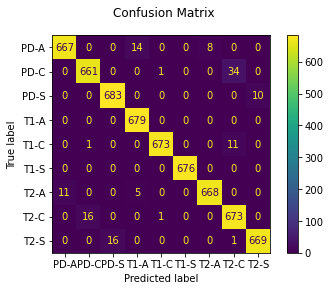

In [65]:
# Compute the overall accuracy of the model on the test dataset 
test_loss, test_accuray = model.evaluate(X_test, y_test, verbose=1)
print('Test accuracy:', test_accuray)

# Compute and display standart classication metrics, i.e. precision, recall, f1-score, support and confusion matrix 
ClassificationReport(model, X_test, y_test, class_names)

### <span style="color:red"> **Questions**
- Now that you have completed your first learning from scratch, go back to the cell that allows you to modify the network parameters in order to perform new learning to see the influence of certain parameters. For example, you can play on the following parameters: <em>nb_epochs</em>, <em>learning_rate</em> et <em>nb_mlp_neurons</em>. To explore efficiently those parameters, multiply or divide by 2 or 10 their values.
- Add an additional fully connected layers by adding "tf.keras.layers.Dense()" functions in the sequential declaration of the model.
- Try to get the best possible performance (ie accuracy > 97% ).
- Compare the scores between the FCN and the random forest model.

### <span style="color:brown"> **D2 - Convolutional Neural Network (CNN)**

In order to try to improve the results, we are now looking at convolutional neural networks, of which an example architecture is provided below.

<center><img src="./figures/architecture_cnn_en.png" alt="Architecture CNN" style="width: 90%"/></center>


<span style="color:#ff7800"><b>Comment</b>: The interest of these kinds of networks is to add a succession of convolution layers in order to create an efficient (discriminating) representation of the data before the classification stage. These convolution layers also allow to significantly reduce the number of network parameters, which is a determining factor in the perspective of deploying these solutions in clinical routine (the fewer the parameters, the faster the network will run).</span>

<span style="color:#ff7800"><b>Comment</b>: You can play with the value of some typical parameters by executing the cell below. During your session, feel free to go back to this cell, change some values and re-run the code from this cell to see the impact on the results.</span>

In [66]:
# Definition of variables that you will have to play with during the session to study their influence

# Variables related to the FCN architecture
nb_mlp_neurons = 16    # Number of neurons for one layer
nb_cnn_neurons = 16    # number of feature maps

# Variables related to the optimization process
batch_size    = 16     # Number of images for each batch during the training process 
nb_epochs     = 5      # number of epochs used during the training process
learning_rate = 0.001  # learning rate used during the training process

Run the cell below to create a CNN (Convolutional Neural Network) model using a sequential declaration allowed by the tensorflow library

In [67]:
# This part of the code allows you to free up memory space 
if 'model' in locals(): 
    print("deleting model")
    del model
    
# Define a CNN model from sequential declaration    
model = tf.keras.Sequential([
  tf.keras.layers.Input(shape=input_shape),
  tf.keras.layers.Conv2D(nb_cnn_neurons//2, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(nb_cnn_neurons, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(nb_cnn_neurons*2, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(nb_mlp_neurons, activation='relu'),  #128
  tf.keras.layers.Dense(num_classes, activation = "softmax")
])

# Display the network structure
model.summary()

deleting model
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 20

### <span style="color:red"> **Questions**
- Analyze the description of the network that appears after the execution of the cell above and try to make the link with the CNN diagram given above.    
- How many parameters does this network have in total ?
- Compare this value with the one of the FCN studied above.
- How can you explain this favourable difference ?

Run the cell below to train the CNN model

In [68]:
# Compile (define the optimization scheme) the model to be ready for training
model.compile(
  optimizer=optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
  loss=tf.losses.CategoricalCrossentropy(),
  metrics=['accuracy'])

# Train the model
model.fit(
  X_train, y_train,
  validation_data=(X_val, y_val),
  batch_size=batch_size,  
  epochs=nb_epochs
)

Epoch 1/5


2022-07-17 15:08:57.696708: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-07-17 15:08:58.938342: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-07-17 15:08:59.050204: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1221/1221 [==============================] - 22s 11ms/step - loss: 0.7441 - accuracy: 0.7263 - val_loss: 0.0716 - val_accuracy: 0.9812
Epoch 2/5
1221/1221 [==============================] - 3s 2ms/step - loss: 0.0584 - accuracy: 0.9814 - val_loss: 0.0374 - val_accuracy: 0.9865
Epoch 3/5
1221/1221 [==============================] - 3s 2ms/step - loss: 0.0333 - accuracy: 0.9878 - val_loss: 0.0268 - val_accuracy: 0.9939
Epoch 4/5
1221/1221 [==============================] - 3s 2ms/step - loss: 0.0238 - accuracy: 0.9914 - val_loss: 0.0237 - val_accuracy: 0.9934
Epoch 5/5
1221/1221 [==============================] - 3s 2ms/step - loss: 0.0127 - accuracy: 0.9958 - val_loss: 0.0144 - val_accuracy: 0.9947


Run the cell below to evaluate the performance of the model on the test dataset.

194/194 [==============================] - 7s 19ms/step - loss: 0.0196 - accuracy: 0.9947
Test accuracy: 0.9946584701538086
Prediction on test images
Classification report :
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       689
           1       0.99      1.00      0.99       696
           2       1.00      1.00      1.00       693
           3       1.00      0.99      0.99       679
           4       1.00      0.99      1.00       685
           5       1.00      1.00      1.00       676
           6       0.98      1.00      0.99       684
           7       0.99      0.99      0.99       690
           8       1.00      1.00      1.00       686

    accuracy                           0.99      6178
   macro avg       0.99      0.99      0.99      6178
weighted avg       0.99      0.99      0.99      6178




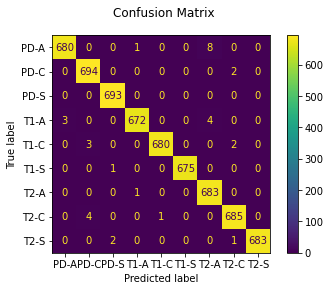

In [69]:
# Compute the overall accuracy of the model on the test dataset 
test_loss, test_accuray = model.evaluate(X_test, y_test, verbose=1)
print('Test accuracy:', test_accuray)

# Compute and display standart classication metrics, i.e. precision, recall, f1-score, support and confusion matrix 
ClassificationReport(model, X_test, y_test, class_names)

### <span style="color:red"> **Questions**
- From the cells allowing to modify the network architecture as well as the optimisation parameters, try to get the best possible performance (if necessary...).
- Compare the scores between the CNN and FCN models.
- Is there a big difference? What conclusions can you draw from this ?

### <span style="color:brown"> **D3 - Residual deep network and transfer learning (fine tuning)**
    
We will now conclude this hands-on session by working on one of the most powerful networks currently used for image classification, namely the resnet model whose architecture is recalled below. 

<center><img src="./figures/architecture_resnet_en.png" alt="Architecture ResNet" style="width: 60%"/></center>


This architecture is very deep and potentially challenging to train. In order to be efficient, the use of such an architecture for a given application is usually done through a particular strategy, called transfer learning.

The idea behind transfer learning is to reuse the weights of a part of the network that have already been learned from large databases, such as imagenet. This section of the architecture, named base, corresponds to the set of layers before the classification part. Thus, for a given application, the base part of the resnet with the associated pre-trained weights is selected first. A dedicated classification subnetwork (i.e. a fully connected network) is then added at the end to form a new architecture. During the training phase, only the weights of the network's head (i.e. the classification part) are optimized, making the learning process faster.

In the remainder of this hands on session, you will create such a resnet-based architecture using transfer learning strategy.

<span style="color:#ff7800"><b>Comment</b>: You can play with the value of some typical parameters by executing the cell below. During your session, feel free to go back to this cell, change some values and re-run the code from this cell to see the impact on the results.</span>

In [75]:
# Definition of variables that you will have to play with during the session to study their influence

# Variables related to the FCN architecture
nb_mlp_neurons = 16    # Number of neurons for one layer

# Variables related to the optimization process
batch_size  = 16       # Number of images for each batch during the training process 
nb_epochs   = 5          # number of epochs used during the training process
learning_rate = 0.001  # learning rate used during the training process

Run the cell below to create a resnet-based model using a predifined structure from the tensorflow library.
This code is explained in the figure below

In [76]:
# This part of the code allows you to free up memory space 
if 'model' in locals(): 
    print("deleting model")
    del model

# transfer learning / fine tuning head (classification part) only
print(" ResNET50 network is trained with RGB natural images, so we use the RGB train and test datasets.")
    
# Define input and preprocessed them to fit the conditions used for the predifined resent model 
inputs = tf.keras.layers.Input(shape=input_shape_rgb)
x = tf.cast(inputs, tf.float32)
outputs_preproc = tf.keras.applications.resnet_v2.preprocess_input(x)  # pixels values are changed to [-1;1]

# Define the ResNet architecture and dowload weights trained on imagenet
baseModel = tf.keras.applications.ResNet50V2(
    weights="imagenet", # use "imagenet" to use imagenet resnet weights, or None (!! no " ") for random initialization of network parameters
    include_top=False,  # don't include the fully-connected layers (classification part) at the top of ResNet
    input_tensor=tf.keras.layers.Input(shape=input_shape_rgb))

# Link outputs of preprocessing as intput of baseModel
outputs_base = baseModel(outputs_preproc)

# Create the model of preproc + resnet without 'top' or 'head'
baseModel_preproc = tf.keras.Model(inputs=[inputs], outputs=[outputs_base]) 
    
# Define the head model i.e. the part that is flattenning alls features extracted before and then classify the data
# and which is fully connected (MLP...) in order to obtain the classification
headModel = baseModel_preproc.output
headModel = tf.keras.layers.Flatten(name = "flatten")(headModel)
headModel = tf.keras.layers.Dense(nb_mlp_neurons, activation = "relu")(headModel)
outputs_head = tf.keras.layers.Dense(num_classes, activation = "softmax")(headModel)

# Create the final resnet-base model
model = tf.keras.Model(inputs=[inputs], outputs=outputs_head)

# allow baseModel weights to be trainable ? (if True, the training step will be long i.e. 1 to 3 minutes per epoch)
baseModel.trainable = False

# Display the network structure on the console
model.summary()

# uncomment to see ResNet50 architecture (it is a deep network :p )
#baseModel.summary()


deleting model
 ResNET50 network is trained with RGB natural images, so we use the RGB train and test datasets.
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
tf.cast_1 (TFOpLambda)       (None, 64, 64, 3)         0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 64, 64, 3)         0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 64, 64, 3)         0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 2, 2, 2048)        23564800  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_____________

<center><img src="./figures/ResNet_TransferLearning.png" alt="ResNet Transfer Learning schme" style="width: 60%" /></center>

### <span style="color:red"> **Questions**
- Analyze the description of the network that appears after the execution of the cell above and try to make the link with the diagram given above.    
- How many parameters does this network have in total ?
- Compare this value with the one of the CNN studied above.
- Where do the differences come from?

In [77]:
# Compile (define the optimization scheme) the model to be ready for training
model.compile(
  optimizer=optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999),
  loss=tf.losses.CategoricalCrossentropy(),
  metrics=['accuracy'])

# Train the model
model.fit(
  X_train_rgb, y_train,
  validation_data=(X_val_rgb, y_val),
  batch_size=batch_size,  
  epochs=nb_epochs
)

Epoch 1/5
1221/1221 [==============================] - 17s 12ms/step - loss: 0.3568 - accuracy: 0.8945 - val_loss: 0.0572 - val_accuracy: 0.9822
Epoch 2/5
1221/1221 [==============================] - 14s 12ms/step - loss: 0.0443 - accuracy: 0.9874 - val_loss: 0.0430 - val_accuracy: 0.9883
Epoch 3/5
1221/1221 [==============================] - 15s 12ms/step - loss: 0.0192 - accuracy: 0.9930 - val_loss: 0.0423 - val_accuracy: 0.9844
Epoch 4/5
1221/1221 [==============================] - 15s 12ms/step - loss: 0.0278 - accuracy: 0.9914 - val_loss: 0.0792 - val_accuracy: 0.9805
Epoch 5/5
1221/1221 [==============================] - 15s 12ms/step - loss: 0.0194 - accuracy: 0.9939 - val_loss: 0.0309 - val_accuracy: 0.9918


Run the cell below to evaluate the performance of the model on the test dataset.

194/194 [==============================] - 2s 12ms/step - loss: 0.0531 - accuracy: 0.9882
Test accuracy: 0.988183856010437
Prediction on test images
Classification report :
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       689
           1       0.99      0.99      0.99       696
           2       0.99      1.00      0.99       693
           3       0.97      0.99      0.98       679
           4       0.99      1.00      0.99       685
           5       1.00      0.99      1.00       676
           6       1.00      0.98      0.99       684
           7       0.99      0.99      0.99       690
           8       0.99      0.99      0.99       686

    accuracy                           0.99      6178
   macro avg       0.99      0.99      0.99      6178
weighted avg       0.99      0.99      0.99      6178




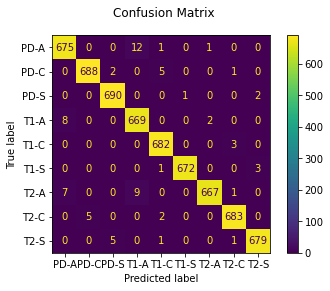

In [78]:
# Compute the overall accuracy of the model on the test dataset 
test_loss, test_accuray = model.evaluate(X_test_rgb, y_test, verbose=1)
print('Test accuracy:', test_accuray)

# Compute and display standart classication metrics, i.e. precision, recall, f1-score, support and confusion matrix 
ClassificationReport(model, X_test_rgb, y_test, class_names)

### <span style="color:red"> **Questions**
- From the cells allowing to modify the network architecture as well as the optimisation parameters, try to get the best possible performance.
- The training time is longer, why ? 
- Is the accuracy better than previous and smaller network? Have a look at the number of trainable parameters...
- [long test] Is the accuracy better if all weights of the network can be trained ? (i.e. including the ones of baseModel)
- [very long test] How to assess the role of the initial weights coming from imagenet ? (by the way : what is imagenet?)

In [ ]:
# Restore the best weights according val_loss
# don't execute this cell! 
#   copy and adapt it in the previous cells...

from tensorflow.keras.callbacks import EarlyStopping

callback_earlystopping = EarlyStopping(
    monitor='val_loss', #'val_loss'
    mode ='auto', # use 'min' or 'auto' if val_loss
    patience=NBPATIENCE_EPOCHS,
    restore_best_weights=True  # at the end of fitting, restore best model weights 
)

model.fit(
  X_train_rgb, y_train,  # or X_train, y_train,
  validation_data=(X_val_rgb, y_val), # or (X_val, y_val)
  batch_size=batch_size,  
  epochs=nb_epochs,
  callbacks=[callback_earlystopping]
)